<span style="color:red">This is my first attempt and rough draft of Project 1.</span>
$\newcommand{\pa}[1]{\left(#1\right)}$

In [1]:
from IPython.display import display, Math
import numpy as np
import matplotlib.pyplot as plt
plt.matplotlib.style.use("ggplot")

# Project 1: *To Brake or Not to Brake?*
**PHY432: Computational Methods in Physics**  
**Agustin Garcia Flores**  
**Dr. Oliver Beckstein**

A driver in a car approaches an intersection with constant speed $v_0 = 55$ km/h.
She sees the traffic light switch from green to yellow when she is at a distance $x_0$ from the intersection.
She has to decide
- to brake (with deceleration $a = 3$ m/s$^2$) or
- to continue driving with constant $v_0$.

Any reaction is delayed by the driver’s reaction time $\delta = 0.8$ s.
The yellow interval (time between green and red) is $\tau = 3$ s and the width of the
intersection is $W = 30$ m. We ignore the length of the car.
Take the entrance of the intersection and the position of the traffic light to be at $x_0$.

Our task will be to determine if there are situations in which the driver
will not be able to adhere to the traffic code, i.e., if she will either run a
red light or not clear the intersection before the traffic light has switched
to red. In particular, we should find out if there is a starting position $\pa{x^B_0}$
before which braking is safe (i.e., the car will stop before the traffic light)
and if there is a starting position $\pa{x^A_0}$ beyond which crossing the intersection
is safe (i.e., the car will cross the intersection before the light has switched from yellow to red).

Under certain conditions there can exist a range of values $x^B_0 < x_0 < x^A_0$
where neither the decision to drive across the intersection nor to brake will
be successful and therefore lead to a dangerous traffic situation. This range
of values is called the dilemma zone. The size of the dilemma zone is  
$$s := x^A_0 - x^B_0$$
and the dilemma zone exists when $s>0$.

<img src="intersection_figure.png" width="500">

## (a) Equations of Motion

The standard kinematic equations for position and velocity are $r_x(t) = \frac{1}{2}at^2+v_{x_0}t+r_{x_0}$, $v_x(t) = at+v_{x_0}$, and similar expressions for the $y$-component of motion. However, in this problem we have one-dimensional motion, say, the $x$ direction, with $x=0$ at the beginning of the intersection. Thus our equations of motion can be expressed as $x(t) = \frac{1}{2}at^2+v_0t+x_0$ and $v(t) = at+v_0$. We know that $v_0 = 55$ km/h, so converting this SI Base Units we see that $v_0 = \pa{55 \text{ km/h}}\pa{\frac{1000 \text{ m}}{1 \text{ km}}}\pa{\frac{1 \text{ h}}{60 \text{ min}}}\pa{\frac{1 \text{ min}}{60 \text{ s}}}$

In [2]:
v0 = 55*1000*(1/60)*(1/60) # m/s
display(Math(f'v_0 \\approx {v0: .0f} \\text{{ m/s}}.'))

<IPython.core.display.Math object>

### [i] To Brake

From the background information, we know that when the driver decides to brake her acceleration is $a = -3$ m/s$^2$ (negative since it goes against the motion). We also know that any reaction from the driver is delayed by $\delta = 0.8$ s, so for the first $0.8$ s the velocity remains unchanged, $v(t) = v_0$, but immediately after the $0.8$ s the driver reacts and applies the acceleration, $v(t) = -3t+v_0$. Note that the main difference here is the acceleration: for first $0.8$ s, $a = 0$ m/s$^2$ and thereafter $a = -3$ m/s$^2$. Hence, 
\begin{equation}
a(t) = 
\left\{
    \begin{array}{lr}
        0, & 0\leq t \leq 0.8; \\
        -3, & 0.8 < t.
    \end{array}
\right.
\end{equation}
In other words, since the velocity equation includes the acceleration,
$$\boxed{\begin{equation}
v(t) = 
\left\{
    \begin{array}{lr}
        v_0, & 0\leq t \leq 0.8; \\
        -3t+v_0, & 0.8 < t.
    \end{array}
\right.
\end{equation}}$$
We can then conclude that the position equation also has a similar structure:
$$\boxed{\begin{equation}
x(t) = 
\left\{
    \begin{array}{lr}
        v_0t+x_0, & 0\leq t\leq 0.8; \\
        -\frac{3}{2}t^2+v_0t+x_0, & 0.8 < t.
    \end{array}
\right.
\end{equation}}$$

### [ii] Not to Brake

When the driver decides not to brake they continue their velocity does not change, so $$\boxed{v(t) = v_0,}$$ implying that their motion continues linearly, $$\boxed{x(t) = v_0t+x_0.}$$

## (b) Equations of Motion as Python Functions

Note, since our equations of motion included jump discontinuities, I'm thinking we ought to employ the Heaviside step function,
\begin{equation}
\Theta(x) = 
\left\{
    \begin{array}{lr}
        0, & x < 0; \\
        0.5, & x = 0; \\
        1, & x > 0.
    \end{array}
\right.
\end{equation}
Namely, I say we use it to define the acceleration in the following way:
\begin{equation}
a(t) = 
\left\{
    \begin{array}{lr}
        0, & 0\leq t < 0.8; \\
        -1.5, & t = 0.8; \\
        -3, & t > 0.8,
    \end{array}
\right.
\end{equation}
we note that this is equivalent to multiplying the Heaviside step function by $-3$ and shifting the argument to the right by 0.8.

### [i] Python Functions

Firs of all, we need to make sure that once the velocity reaches $0$ m/s that it stays at $0$ m/s. Also, we need to make sure that when $x(t)$ reaches a maximum it remains at that maximum. Or, in other words, if for some $t_0\in t$, $v(t_0) = 0$, then $\forall t_1 > t_0, ~ x(t_1) = x(t_0)$. These functions are made to control this:

In [3]:
def nonnegative(v):
    """Replaces negative values in v with 0"""
    v_nonnegative = np.where(v < 0, 0, v)
    return v_nonnegative

def maximum(x):
    """Makes x constant once it reaches its maximum value"""
    max_value = x[0]
    new_x = np.empty_like(x)
    for index, value in enumerate(x):
        if value > max_value:
            max_value = value
        new_x[index] = max_value
    return new_x

We can now commence the definition of variables. We start off by defining an acceleration function as follows:

In [4]:
def acceleration(t, origin=0.8):
    """Shifting the 't' array by some 'origin'
    in order to properly define the Heaviside
    step function"""
    t_values = t - origin # s
    
    """We then define a from the Heaviside step
    function times a constant"""
    a = -3*np.heaviside(t_values, 0.5) # m/s^2
    
    return a

This allows to create an array of values like what we defined up above for $a(t)$. We can now use this to define two new functions, one for braking and one for driving, which create arrays for the corresponding positions and velocities.

In [5]:
def braking(t, x0, v0=v0):
    """Creating the acceleration array"""
    a = acceleration(t) # m/s^2
    
    """Creating the velocity array from 'a' and 't'"""
    v = nonnegative(a*t+v0) # m/s
    
    """Creating the position array from 'a' and 't'"""
    x = maximum((1/2)*a*(t**2)+v0*t+x0) # m
    
    return x, v

def driving(t, x0, v0=v0):
    """Creating the velocity array with constant value v0"""
    v = nonnegative(np.full(t.shape, v0)) # m/s
    
    """Creating the position array from 't'"""
    x = maximum(v0*t+x0) # m
    
    return x, v

### [ii] Plots

We now want to plot $x(t)$ and $v(t)$ for $0\leq t\leq 7$ in time steps of $\Delta t = 0.1$ s. We define a variable $t$ in the following way:

In [6]:
t = np.arange(0.0, 7.1, 0.1) # s
# Note that we go up to 7.1 in order to include t = 7

We want to use three different values for $x_0$; namely, $-30$ m, $-70$ m, and $-0.5$ m. In order to avoid having to copy and paste the same code for all three figures, we define a function that takes in some $x_0$, some *value* which tells it which 'case' it is, and the $t$ array.

In [7]:
def make_plot(x0, value, t_values=t):
    # Find the 
    x_brake, v_brake = braking(t_values, x0)
    x_drive, v_drive = driving(t_values, x0)

    # Create a figure and a set of subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

    # First subplot for velocity
    ax1.plot(t_values, v_brake, label='Braking')
    ax1.plot(t_values, v_drive, label='Driving')
    ax1.axvline(x=3, color='red', linestyle='--')  # Dashed red line at t = 3
    ax1.set_title('Velocity vs. Time')
    ax1.set_xlabel(r'Time, $t$ (s)')
    ax1.set_ylabel(r'Velocity, $v$ (m/s)')
    ax1.legend()

    # Second subplot for position
    ax2.plot(t_values, x_brake, label='Braking')
    ax2.plot(t_values, x_drive, label='Driving')
    ax2.fill_between(t, 0, 30, color='gray', alpha=0.5)  # Shaded area between x = 0 and x = 30
    ax2.axvline(x=3, color='red', linestyle='--')  # Dashed red line at t = 3
    ax2.set_title('Position vs. Time')
    ax2.set_xlabel(r'Time, $t$ (s)')
    ax2.set_ylabel(r'Position, $x$ (m)')
    ax2.legend()

    # Overall title for the figure
    fig.suptitle(fr'Case {value}: $x_0 = {x0}$ m')

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Display the plot
    plt.show()

We now print three separate plots, one for each case:

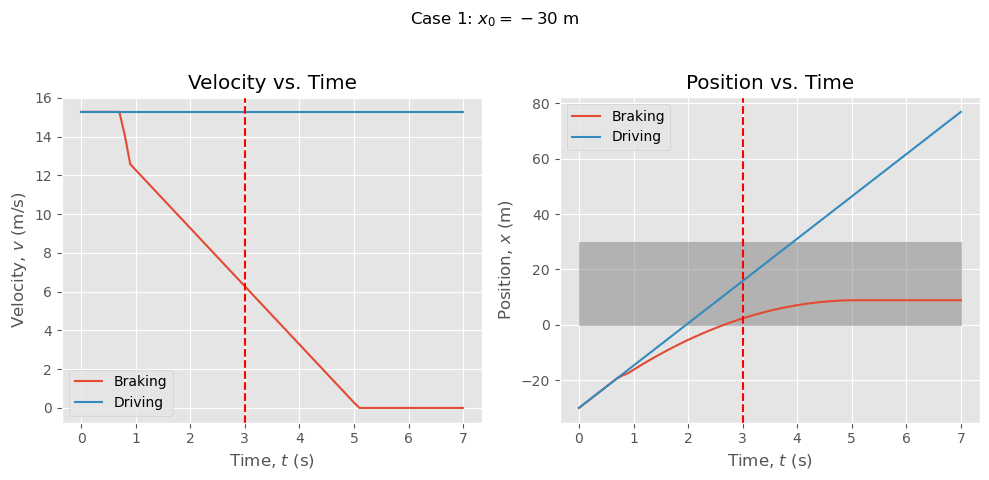

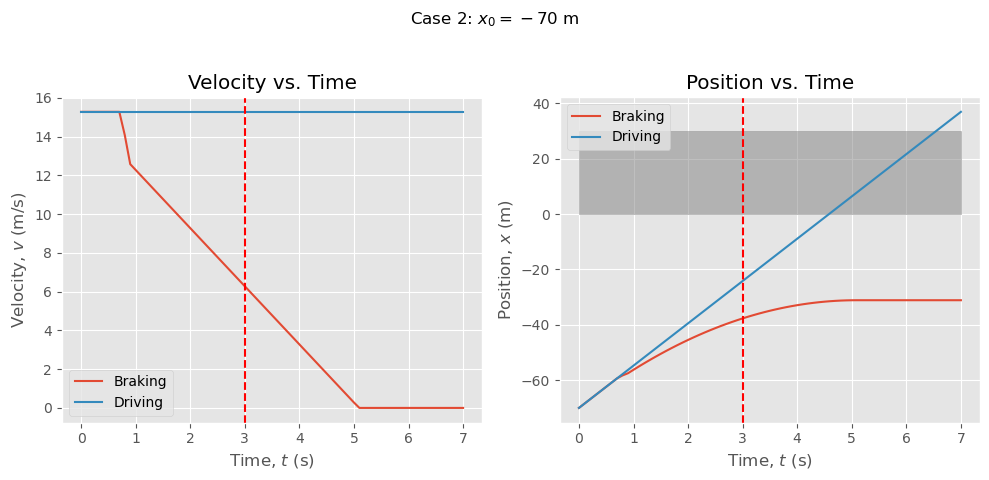

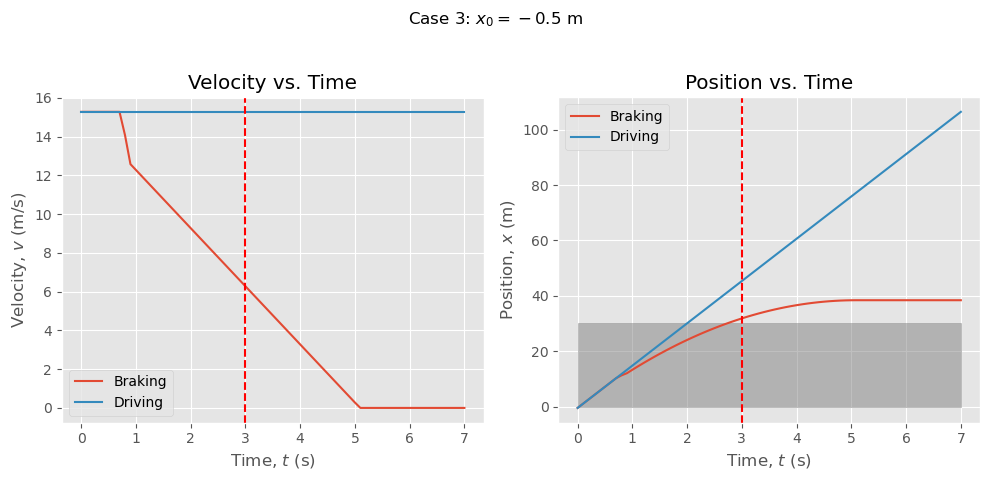

In [8]:
make_plot(-30, 1) # Case 1: x0 = -30
make_plot(-70, 2) # Case 2: x0 = -70
make_plot(-0.5, 3) # Case 3: x0 = -0.5

We see that the Velocity vs. Time graphs, in every case, is identical. This is because the equation for $v(t)$ doesn't depend on $x_0$, which is what we were changing. The driver does not adhere to the traffic code if she will run a red light or not clear the intersection before the traffic light has switched to red. In essence we are seeing if the plots pass the gray region prior to the red line.
 - From Case 1: $x_0 = -30$ m, we see that when the light turns red the driver is still in the intersection, regardless of whether or not she brakes. Both scenarios in Case 1 are dangerous.
 - From Case 2: $x_0 = -70$ m, we see that when the driver does not brake she enters the intersection long after the light has already turned red. When the driver brakes, she manages to stop well before reaching the intersection. Although this may be dangerous in a real life scenario, this is not considered dangerous in our problem.
 - From Case 3: $x_0 = -0.5$ m, the driver manages to clear the intersection in both instances, but when braking she stops after crossing the intersection, which, again, is dangerous in a real life scenario but not considered dangerous in our problem.

## (c) Safe or Dangerous?

In this section, we will computationally classify outcomes as either safe or dangerous, depending on $x_0$, by considering the following steps:
 - For a given $x_0$, calculate the time series of the velocities $v_{\text{drive}}(t)$ and positions $x_{\text{drive}}(t)$ when the decision is made to attempt to drive across the intersection.
 - Also calculate the time series $v_{\text{brake}}(t)$ and $x_{\text{brake}}(t)$ for the decision to brake. Use a range of time points $0\leq t\leq t_{\text{max}}$ and $\Delta t = 0.1$ s, with $t_{\text{max}}$ sufficiently large to see the car to come to a stop or to cross the intersection.

Analyze the position trajectories $x(t)$ for driving/braking: The outcome is safe if

<p style="text-align: center;">when driving, $x > W$ for $t > \tau$, or when braking $x < 0$ for all t,</p>

otherwise it is dangerous. For a given $x_0$, the outcome is safe if there is at least one safe course of action. Use your computational approach to determine if the situation is safe for $x_0 = -70$ m, $-30$ m, and $-0.5$ m. Discuss if your algorithmic decision making (your situation classification algorithm) agrees with your analysis of your plots in (b) (the “human expert” analysis).

The safety conditions make sense logically, now I must figure our how to check them computationally. Let's evaluate each condition separately.

### [i] When driving, $\forall t > \tau, ~ x(t) > W$

Since $\tau = 3$ s and $\Delta t = 0.1$, we must ensure that for $t > \tau \Rightarrow t = \tau + \Delta t = 3 + 0.1 = 3.1$ s, $x(t) > W \Rightarrow x(3.1) > 30$ m.

For now, let's focus on making a function which determines if this criterion is met for some given $x_0$. I want said function to return boolean values, so I'll make another function which interprets those Boolean results as either safe or dangerous conditions.

In [9]:
def safe_print(state):
    """This function takes in a Boolean and
    prints whether the condition is safe or
    dangerous."""
    if state == True:
        print('Safe!')
    elif state == False:
        print('Dangerous!')

In [10]:
def safe_driving(x0, t_max=3.1, t_step=0.1):
    """This function checks if x(3.1) > 30"""
    # Creating a time array from 0 to t_max
    t_values = np.arange(0, t_max+t_step, t_step)
    
    # Creating a time series for x and v
    x_values, v_values = driving(t_values, x0)
    
    # Checking if x(3.1) > 30 m
    if x_values[-1] > 30:
        return True
    else:
        return False

In [11]:
# x0 = float(input("What is the starting position? "))
# safe_print(safe_driving(x0))

### [ii] When braking, $\forall t, ~ x(t) < 0$

Here we are ensuring that $\forall t\in \text{dom } x$, $x(t) < 0$. In essence, the maximum of $x(t)$ must be less than $0$; that's what we'll use to check for safety.

In [12]:
def safe_braking(x0, t_max=3.1, t_step=0.1):
    """This functions check if the maximum of x(t) < 0."""
    # Creating a time array from 0 to t_max
    t_values = np.arange(0, t_max+t_step, t_step)
    
    # Creating a time series for x and v
    x_values, v_values = braking(t_values, x0)
    
    # Checking if max(x) < 0
    if np.max(x_values) < 0:
        return True
    else:
        return False

In [13]:
# x0 = float(input("What is the starting position? "))
# safe_print(safe_braking(x0, 90))

### [iii] Concluding Safety

Now that we have two separate tests for safety, one for driving and another for braking, we can combine them to check for safety in general. We first note that both conditions need not be true for it to be safe, so both conditions must be simultaneously false for it to be dangerous.

In [14]:
def safety_check(x0, t_max=3.1, t_step=0.1):
    """This function checks if there is a safe option
    between either driving or braking, given an x0."""
    # Fetching Booleans
    drive = safe_driving(x0, t_max, t_step)
    brake = safe_braking(x0, t_max, t_step)
    
    # Checking for safety
    if drive == brake == False:
        return False
    else:
        return True

We now check if the situation is safe for $x_0 = -70$ m, $-30$ m, and $-0.5$ m.

In [15]:
x0 = [-70, -30, -0.5]
for val in x0:
    display(Math(f"x_0 = {val} \\text{{ is }}"))
    safe_print(safety_check(val))

<IPython.core.display.Math object>

Safe!


<IPython.core.display.Math object>

Dangerous!


<IPython.core.display.Math object>

Safe!


## (d) Mapping Dangerous Regions

In this section we will map out the zone of values of $x_0$ that lead to dangerous situations, i.e., that do not allow the driver to either brake or complete the crossing of the intersection in time. We will run the calculations for $x_0$ ranging from $-100$ m to the entrance of the intersection $x_0 = 0$ m in $0.1$ m intervals and for time intervals with $\Delta t = 1\times 10^{-3}$ s. Finally, we determine for each $x_0$ if it allows for a safe decision or not.

### [i] Via Plots

We start by defining an array for $x_0$ and checking for safety at each value.

In [16]:
# Defining our array for x0 values
x0 = np.arange(-100, 0.1, 0.1)
# Defining the time step value
dt = 1e-3
# Creating array of Boolean values
safe_region = np.array([safety_check(val, t_step=dt) for val in x0])

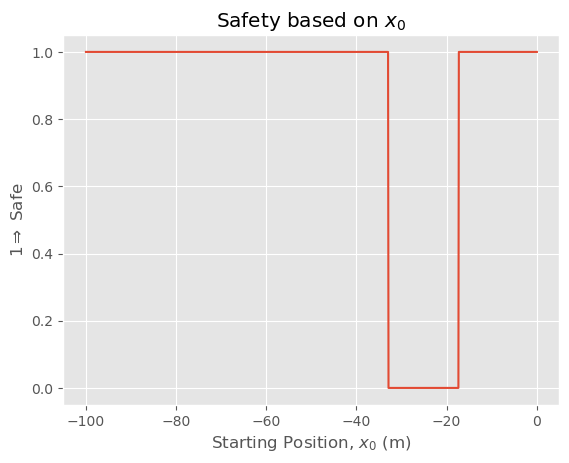

In [17]:
plt.plot(x0, safe_region)
plt.title(r'Safety based on $x_0$')
plt.xlabel(r'Starting Position, $x_0$ (m)')
plt.ylabel(r'$1\Rightarrow$ Safe');

The plot assigns safe starting positions with a value of $1$ and dangerous starting positions with a value of $0$. We see a danger zone between $\sim -18$ m and $\sim -32$ m from the plot but let's find some more accurate values using a similar approach as shown above.

### [ii] Via Loops

We will run similar calculations as we did to make the plot, but now we will run the calculations for $x_0$ ranging from $-100$ m to the entrance of the intersection $x_0 = 0$ m in $0.01$ m intervals and for time intervals with $\Delta t = 1\times 10^{-3}$ s. First, we will make a function that takes in an array of Boolean values and finds the first and last occurences of a **False** value.

In [18]:
def find_false(array):
    # Find indices of all occurrences of False
    false_indices = np.where(array == False)[0]

    # First and last occurrence of False
    first_false = false_indices[0]
    last_false = false_indices[-1]

    return first_false, last_false

In [19]:
# Defining our array for x0 values
x0 = np.arange(-100, 0.01, 0.01)
# Defining the time step value
dt = 1e-3
# Creating array of Boolean values
safe_region = np.array([safety_check(val, t_step=dt) for val in x0])

We utilize the above to determine the numerical values of the dilemma zone $x_0^A$, $x_0^B$ and $s$ from the data to at least two decimals precision. Recall $$s:= x^A_0 - x^B_0.$$

In [20]:
first, last = find_false(safe_region)
x0A, x0B = x0[last], x0[first]
s = x0A - x0B

display(Math(f"\\text{{The numerical values of the dilemma zone are }} \
    x_0^A = {x0A: .2f}, ~ x_0^B = {x0B: .2f}, \\text{{ and }} s = {s: .2f}."))

<IPython.core.display.Math object>

## (e) Analytical Solution

Recall our equations from above for braking:
$$\begin{align}
x_b(t) = 
\left\{
    \begin{array}{lr}
        v_0t+x_0, & 0\leq t\leq \delta; \\
        -\frac{3}{2}t^2+v_0t+x_0, & \delta < t,
    \end{array}
\right. ~~~ & ~~~ v_b(t) = 
\left\{
    \begin{array}{lr}
        v_0, & 0\leq t \leq \delta; \\
        -3t+v_0, & \delta < t.
    \end{array}
\right.
\end{align}$$
Also recall the ones for driving:
$$x_d(t) = v_0t+x_0, ~~~~~~ v_d(t) = v_0.$$
Furthermore, recall that in order for the driver to safely continue driving, $\forall t > \tau, ~ x_d(t) > W$. For the driver to safely brake, $\forall t, ~ x_b(t) < 0$.

### [i] For Driving

We tackle the solution for driving first. For the driver to safely continue driving, $\forall t > \tau, ~ x_d(t) > W$. Note that since the driver is not applying the brake, there is no need to account for any reaction time; our solution will not depend on $\delta$. Thus, over $t > \tau$,

\begin{align}
x_d(t) &= v_0t+x_0, \\
&> v_0\tau +x_0, \\
&> W;
\end{align}
$$\therefore v_0\tau + x_0 > W \Rightarrow\boxed{x_0 > W - v_0\tau.}$$

Since this is the safe region for the driver to continue driving, $x_0^A$ is where this range begins, so we'll compute $W - v_0\tau$ as $x_0^A$:

In [21]:
# Assigning values to variables
W = 30 # m
tau = 3 # s

x0A_analytical = W - v0*tau

display(Math(f"\\text{{The analytical value for }} x_0^A \\text{{ is }} {x0A_analytical: .2f}"))

<IPython.core.display.Math object>

### [ii] For Braking

For the driver to safely brake, $\forall t, ~ x_b(t) < 0$. Since $v_b(t) = \frac{dx_b(t)}{dt}$, if we set $v_b(t) = 0$ we can see where $x_b(t)$ stops increasing. Recall $$v_b(t) = 
\left\{
    \begin{array}{lr}
        v_0, & 0\leq t \leq \delta; \\
        -3t+v_0, & \delta < t,
    \end{array}
\right.$$
we note that $v_b(t) \neq 0$ for $0\leq t \leq \delta$, so $-3t+v_0 = 0 \Rightarrow t = \frac{v_0}{3}$, this is where $x_b(t)$ stops increasing; i.e., the maximum of $x_b(t)$ is $x_b(v_0/3)$.

Since $v_0/3 \notin [0, \delta]$, we focus only on the second piecewise function of $x_b(t)$:

\begin{align}
x_b\pa{\frac{v_0}{3}} &= -\frac{3}{2}\pa{\frac{v_0}{3}}^2+v_0\pa{\frac{v_0}{3}}+x_0 \\
&= -\frac{v_0^2}{6}+\frac{v_0^2}{3}+x_0 \\
&= \frac{v_0^2}{6} + x_0.
\end{align}

We want this value to be negative, so

$$\frac{v_0^2}{6} + x_0 < 0 \Rightarrow\boxed{x_0 < -\frac{v_0^2}{6}.}$$

Again, this is when the safety region begins for braking, so we'll take where this range begins as $x_0^B$:

In [22]:
x0B_analytical = - v0**2 / 6

display(Math(f"\\text{{The analytical value for }} x_0^B \\text{{ is }} {x0B_analytical: .2f}"))

<IPython.core.display.Math object>

Thus, since $s := x_0^A - x_0^B$, we see that

In [23]:
s_analytical = x0A_analytical - x0B_analytical

display(Math(f"\\text{{The analytical value for }} s \\text{{ is }} {s_analytical: .2f}"))

<IPython.core.display.Math object>

We see that the analytical value for $s$ is greater than the computational one. This could be due to us using discrete iterations with a relatively large time steps. Increasing the time step (and the step in $x_0$) would improve our computational results, but they would also increase the computational power necessary. The relative error for each of the values can also be computed, as shown below:

In [28]:
diff_x0A = np.abs((x0A - x0A_analytical) / x0A_analytical)
diff_x0B = np.abs((x0B - x0B_analytical) / x0B_analytical)
diff_s = np.abs((s - s_analytical) / s_analytical)
display(Math(f"\\text{{The relative error for }} s \\text{{ is }} {diff_s: .2f} \\text{{, }} \
    \\text{{the relative error for }} x_0^A \\text{{ is }} {diff_x0A: .2f} \\text{{, }} \
    \\text{{the relative error for }} x_0^B \\text{{ is }} {diff_x0B: .2f} \\text{{.}}"))

<IPython.core.display.Math object>